# Week 11 Midterm: NLP

**Brian Roepke**  
*DATA 110*

For the given dataset, perform the following. 

1.  **Apply Preprocessing and Data Cleansing for the given analysis below:**

     - Add a new column 'Text' that combines both (title and review). This is your text corpus. (Note: if title is null (NaN) replace it with blank string first (before combining the 2 fields)
     - Add column 'text_len'  that counts the length for the derived field


2.  **Full EDA**   

     - show data summary (eg: size, columns, etc)
     - perform statistical analysis and visualization (both univariate and multivariate)


3.  **Sentiment analysis on text features**

    - apply sentiment analysis on the derived 'Text' column
    - use any lexicon-based method (eg: text-blob, vader, etc). 
    - add a column: 'polarity_score' representing the polarity score. Notes below:
        - TextBlob: polarity  >0 (considered positive), <0 (negative) ==0 (neutral)
        - Vader: compound score >= 0.05 (positive), <= -0.05 (negative) else (neutral). Note:  You will need to handle paragraphs (individual sentences) since Vader works on individual sentences. You can aggregate these and calculate the average for example.
    - add a  binary column: 'sentiment' with values 0 (negative), 1 (positive) based on the overall polarity score


4.  **Perform Part-of-speech tagging (for the entire corpus)**

    - show word counts for different parts of speech 
    - What are popular products? identify nouns that can be used to tag the product (eg: dress, jacket, bottom, etc) and show their counts
    - Identify the top adjectives and adverbs for positive vs negative reviews 


5.  **Prediction Model:**

    - create a Supervised ML model to predict whether a product will be Recommended (this is your target),  based on the text features from  (Text) along with the numeric features (text_len, polarity_score)  


6. **Text Classification Model:**

    - create a Supervised ML model to classify products by Department (this is your target) 


**For all models:**
 - apply techniques such as gridSearch, cross-validation, etc. during model building
 - use appropriate model assessment metrics to check model performance
 - test the final model on custom data


**Format your report professionally**  
 - include headings such as Overview, Preprocessing, EDA, Analysis, Conclusion, References, etc..   include text descriptions of analysis in your own words 

 - Do not just copy and paste code from Kaggle, etc.  If you use techniques from your own research, include references.

In [34]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from nltk.chunk import conllstr2tree
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning & EDA

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [4]:
# Change to Categorical types
df["Department Name"] = df["Department Name"].astype('category')
df["Class Name"] = df["Class Name"].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      23486 non-null  int64   
 1   Title                    19676 non-null  object  
 2   Review Text              22641 non-null  object  
 3   Rating                   23486 non-null  int64   
 4   Recommended IND          23486 non-null  int64   
 5   Positive Feedback Count  23486 non-null  int64   
 6   Department Name          23472 non-null  category
 7   Class Name               23472 non-null  category
dtypes: category(2), int64(4), object(2)
memory usage: 1.1+ MB


In [6]:
df.shape

(23486, 8)

### Null Values

In [7]:
# check for nan/null
df.isnull().values.any()

True

In [8]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name              14
Class Name                   14
dtype: int64

In [9]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [10]:
# count of nulls
df.isnull().sum()

Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Department Name               0
Class Name                    0
dtype: int64

In [11]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

In [12]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [13]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [14]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

**Notes**: The title field had some null values.  For any value that was null, it has been filled with an empty string and then concatonated with the text field.

In [15]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [16]:
df.describe()

,Age,Rating,Recommended IND,Positive Feedback Count,text_len
count,22628.000000,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784,326.357036
std,12.328176,1.115911,0.385222,5.787520,147.283745
min,18.000000,1.000000,0.000000,0.000000,12.000000
25%,34.000000,4.000000,1.000000,0.000000,201.000000
50%,41.000000,5.000000,1.000000,1.000000,319.000000
75%,52.000000,5.000000,1.000000,3.000000,478.000000
max,99.000000,5.000000,1.000000,122.000000,557.000000


### Duplicates

In [17]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before-len_after)

Before = 22628
After = 22626

Total Removed = 2


**Note**: After the prior clean up of `NULL` values, there were just `2` duplicates left.

In [18]:
# get categorical data
cat_data = df.select_dtypes(include=['category'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22626 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Department Name  22626 non-null  category
 1   Class Name       22626 non-null  category
dtypes: category(2)
memory usage: 221.9 KB


In [19]:
# show counts values of each categorical variable
for colname in cat_data.columns:
    print (colname)
    print (cat_data[colname].value_counts(), '\n')

Department Name
Tops        10048
Dresses      6145
Bottoms      3661
Intimate     1652
Jackets      1002
Trend         118
Name: Department Name, dtype: int64 

Class Name
Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1103
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               331
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: Class Name, dtype: int64 



## EDA

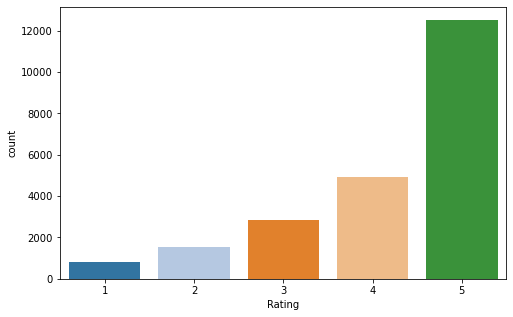

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=df, palette="tab20", dodge=False);

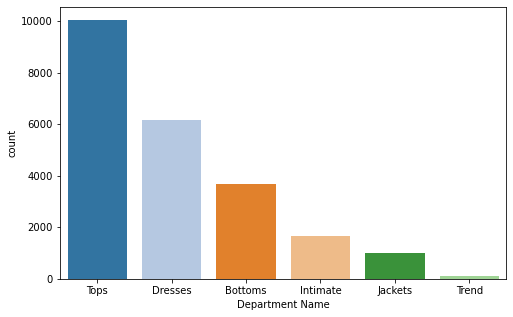

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='Department Name', data=df, palette="tab20", 
              order = df['Department Name'].value_counts().index, dodge=False);

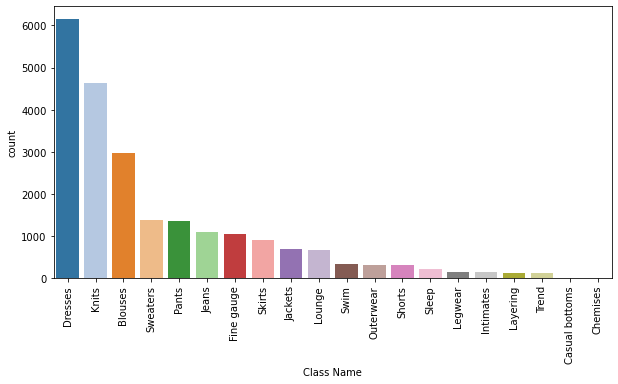

In [22]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Class Name', data=df, palette="tab20", 
                   order = df['Class Name'].value_counts().index, dodge=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

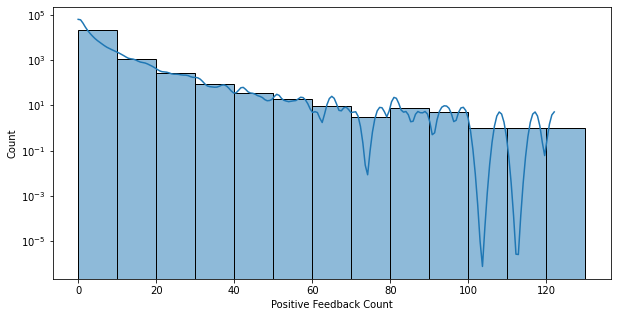

In [23]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(df, x='Positive Feedback Count', kde=True, palette="tab20c", binwidth=10);
ax.set(yscale="log");

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='text_len', kde=True, palette="tab20c", binwidth=10);
# ax.set(yscale="log");

In [ ]:
g = sns.pairplot(df, diag_kind = 'auto', hue = "Recommended IND")
g.fig.set_size_inches(12,12);

# rotate labels
for ax in g.axes.flatten():
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

## Text Cleaning

In [24]:
a = df['Text'][2]
a

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [25]:
def process_string(text, stem=True):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem:
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    else:
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
        
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [26]:
a

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

# Sentiment Analysis

In [27]:
blob = TextBlob(a)

In [28]:
blob.tags

[('Some', 'DT'),
 ('major', 'JJ'),
 ('design', 'NN'),
 ('flaws', 'NN'),
 ('I', 'PRP'),
 ('had', 'VBD'),
 ('such', 'JJ'),
 ('high', 'JJ'),
 ('hopes', 'NNS'),
 ('for', 'IN'),
 ('this', 'DT'),
 ('dress', 'NN'),
 ('and', 'CC'),
 ('really', 'RB'),
 ('wanted', 'VBD'),
 ('it', 'PRP'),
 ('to', 'TO'),
 ('work', 'VB'),
 ('for', 'IN'),
 ('me', 'PRP'),
 ('i', 'NN'),
 ('initially', 'RB'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('petite', 'JJ'),
 ('small', 'JJ'),
 ('my', 'PRP$'),
 ('usual', 'JJ'),
 ('size', 'NN'),
 ('but', 'CC'),
 ('i', 'JJ'),
 ('found', 'VBD'),
 ('this', 'DT'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('outrageously', 'RB'),
 ('small', 'JJ'),
 ('so', 'RB'),
 ('small', 'JJ'),
 ('in', 'IN'),
 ('fact', 'NN'),
 ('that', 'IN'),
 ('i', 'NN'),
 ('could', 'MD'),
 ('not', 'RB'),
 ('zip', 'VB'),
 ('it', 'PRP'),
 ('up', 'RP'),
 ('i', 'NN'),
 ('reordered', 'VBD'),
 ('it', 'PRP'),
 ('in', 'IN'),
 ('petite', 'JJ'),
 ('medium', 'NN'),
 ('which', 'WDT'),
 ('was', 'VBD'),
 ('just', 'RB'),
 ('ok.', 'JJ'),
 ('o

In [33]:
for s in blob.sentences:
    print(s)
    print(s.sentiment.polarity)

Some major design flaws I had such high hopes for this dress and really wanted it to work for me.
0.105625
i initially ordered the petite small (my usual size) but i found this to be outrageously small.
-0.1875
so small in fact that i could not zip it up!
-0.3125
i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers.
0.18621031746031746
imo, a major design flaw was the net over layer sewn directly into the zipper - it c
0.05416666666666667


In [31]:
blob.sentiment

Sentiment(polarity=0.0732093253968254, subjectivity=0.36228174603174607)

In [36]:
blob.correct

<bound method BaseBlob.correct of TextBlob("Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c")>

In [37]:
blob.words.lemmatize

<bound method WordList.lemmatize of WordList(['Some', 'major', 'design', 'flaws', 'I', 'had', 'such', 'high', 'hopes', 'for', 'this', 'dress', 'and', 'really', 'wanted', 'it', 'to', 'work', 'for', 'me', 'i', 'initially', 'ordered', 'the', 'petite', 'small', 'my', 'usual', 'size', 'but', 'i', 'found', 'this', 'to', 'be', 'outrageously', 'small', 'so', 'small', 'in', 'fact', 'that', 'i', 'could', 'not', 'zip', 'it', 'up', 'i', 'reordered', 'it', 'in', 'petite', 'medium', 'which', 'was', 'just', 'ok', 'overall', 'the', 'top', 'half', 'was', 'comfortable', 'and', 'fit', 'nicely', 'but', 'the', 'bottom', 'half', 'had', 'a', 'very', 'tight', 'under', 'layer', 'and', 'several', 'somewhat', 'cheap', 'net', 'over', 'layers', 'imo', 'a', 'major', 'design', 'flaw', 'was', 'the', 'net', 'over', 'layer', 'sewn', 'directly', 'into', 'the', 'zipper', 'it', 'c'])>

In [41]:
b = df['Text'][1]
b

' Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [45]:
neg_blob = TextBlob(b)

In [46]:
neg_blob.sentiment

Sentiment(polarity=0.33958333333333335, subjectivity=0.7250000000000001)

In [47]:
neg_blob.sentences

[Sentence(" Love this dress!"),
 Sentence("it's sooo pretty."),
 Sentence("i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite."),
 Sentence("i bought a petite and am 5'8"."),
 Sentence("i love the length on me- hits just a little below the knee."),
 Sentence("would definitely be a true midi on someone who is truly petite.")]

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
# Apply the Polarity Scoring from Vader
df['vader'] = df['Text'].apply(lambda review: sid.polarity_scores(review))

In [ ]:
# Create a few extra columns to aid in the analysis
df['compound'] = df['vader'].apply(lambda x: x['compound'])
df['vader_score'] = df['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x <= -0.05 else 'neu'))
df['vader_label'] = df['compound'].apply(lambda x: 1 if x >= -0.05 else 0)

In [ ]:
df['Text'][2]

In [ ]:
sid.polarity_scores(df['Text'][2])

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='compound', palette="tab20c", bins=10);

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='vader_score', palette="tab20c");

## Validating Sentiment Predictions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [ ]:
print(metrics.classification_report(df['Recommended IND'], df['vader_label'], digits=3))
print('')

cm = metrics.confusion_matrix(df['Recommended IND'], df['vader_label'], labels=[0,1])
plot_confusion_matrix(cm, classes=[0,1])